In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import dlib
from skimage.feature import local_binary_pattern
from scipy.spatial import ConvexHull
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Path dataset
dataset_path = "data_mentah/"

In [ ]:
# Fungsi untuk mengonversi umur menjadi kategori umur
def categorize_age(age):
    '''
    Fungsi ini mengonversi umur menjadi kategori umur berdasarkan rentang usia.
    Kategori usia yang dihasilkan:
           0 - Anak-anak (1-10 tahun)
           1 - Remaja (11-18 tahun)
           2 - Dewasa (19-59 tahun)
           -1 - Tidak valid (jika usia tidak dalam rentang yang ditentukan)
    '''
    if 1 <= age <= 10:
        return 0  # Anak-anak
    elif 11 <= age <= 18:
        return 1  # Remaja
    elif 19 <= age <= 59:
        return 2  # Dewasa
    return -1  # Label tidak valid

def enhance_with_canny(image, low_threshold=50, high_threshold=150):
    '''
    Meningkatkan citra menggunakan deteksi tepi Canny setelah preprocessing.
    
    Parameter:
    - image: Gambar input (grayscale atau RGB).
    - low_threshold: Threshold bawah untuk deteksi tepi.
    - high_threshold: Threshold atas untuk deteksi tepi.
    
    Return:
    - edges: Citra dengan deteksi tepi menggunakan Canny.
    '''
    # Konversi ke grayscale jika citra berwarna
    if len(image.shape) == 3:  # Jika memiliki 3 kanal (BGR)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Terapkan GaussianBlur untuk mengurangi noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Deteksi tepi menggunakan algoritma Canny
    edges = cv2.Canny(blurred, low_threshold, high_threshold)
    
    return edges

def extract_lbp_from_canny(image, radius=3, n_points=24, method="uniform", low_threshold=50, high_threshold=150):
    '''
    Ekstraksi fitur LBP setelah deteksi tepi menggunakan algoritma Canny.
    '''
    # Deteksi tepi
    edges = enhance_with_canny(image, low_threshold, high_threshold)
    
    # Ekstraksi fitur LBP
    lbp = local_binary_pattern(edges, n_points, radius, method=method)
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)
    return lbp_hist

def process_face_with_canny(image):
    '''
    Pipeline lengkap dengan deteksi wajah menggunakan dlib, diikuti deteksi tepi Canny.
    
    Parameter:
    - image: Gambar input (RGB atau grayscale).
    
    Return:
    - cropped_edges: Citra wajah yang telah diproses dengan deteksi tepi.
    '''
    # Deteksi wajah
    cropped_face = detect_face_dlib(image)
    if cropped_face is None:
        return None  # Tidak ada wajah terdeteksi
    
    # Deteksi tepi dengan Canny
    cropped_edges = enhance_with_canny(cropped_face)
    
    return cropped_edges


# Fungsi untuk ekstraksi fitur LBP
def extract_lbp_features(image, radius=2, n_points=16):
    '''
    Fungsi ini menghitung fitur LBP dari gambar untuk digunakan dalam pengenalan wajah.
    LBP digunakan untuk mengekstraksi informasi tekstur dari gambar wajah.
    
    Parameter:
    image - Gambar input dalam format grayscale.
    radius - Jarak dari titik pusat pada LBP (default: 2).
    n_points - Jumlah titik tetangga pada LBP (default: 16).
    
    Menghasilkan:
    lbp_hist - Histogram yang dinormalisasi dari pola LBP.
    '''
    # Hitung LBP pada gambar
    lbp = local_binary_pattern(image, n_points, radius, method="uniform")
    
    # Hitung histogram dari LBP
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    
    # Normalisasi histogram
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)  # Normalisasi agar jumlah histogram = 1
    return lbp_hist

# Fungsi untuk enhancement citra
def enhance_image(image):
    '''
    Fungsi ini digunakan untuk meningkatkan kualitas gambar dengan menerapkan filter penajaman (sharpening).
    Jika gambar berwarna (BGR), akan dikonversi ke grayscale terlebih dahulu.
    
    Parameter:
    image - Gambar input yang bisa berupa gambar berwarna atau grayscale.
    
    Menghasilkan:
    enhanced_img - Gambar yang telah ditingkatkan kualitasnya dengan filter sharpening.
    '''
    # Periksa apakah citra sudah grayscale
    if len(image.shape) == 3:  # Jika memiliki 3 kanal (BGR)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image  # Jika sudah grayscale, gunakan langsung
    
    # Mendefinisikan kernel sharpening (3x3)
    kernel = np.array([
        [0, -1, 0],
        [-1, 5, -1],
        [0, -1, 0]
    ])
    
    # Melakukan operasi filter untuk sharpening
    enhanced_img = cv2.filter2D(gray, -1, kernel)
    
    return enhanced_img

# Fungsi untuk mendeteksi wajah dan cropping menggunakan dlib
def detect_face_dlib(img):
    # Pastikan citra memiliki 3 channel (RGB) sebelum melakukan konversi ke grayscale
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img  # Jika citra sudah grayscale, langsung digunakan
    
    # Detektor wajah dlib
    detector = dlib.get_frontal_face_detector()
    
    # Prediktor landmarks wajah
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    
    # Deteksi wajah
    faces = detector(gray)
    
    if len(faces) == 0:
        return None  # Jika tidak ada wajah terdeteksi
    
    # Ambil wajah pertama yang terdeteksi
    face = faces[0]
    
    # Prediksi landmarks untuk wajah yang terdeteksi
    landmarks = predictor(gray, face)
    
    # Mengambil koordinat landmarks wajah
    landmarks_points = np.array([[p.x, p.y] for p in landmarks.parts()])
    
    # Menghitung convex hull dari landmarks wajah
    convex_hull = ConvexHull(landmarks_points)
    vertices = convex_hull.vertices
    
    # Membuat mask untuk wajah
    mask = np.zeros(gray.shape, dtype=np.uint8)
    cv2.fillPoly(mask, [landmarks_points[vertices]], 255)
    
    # Memotong wajah menggunakan bounding box dari mask
    x, y, w, h = cv2.boundingRect(mask)
    cropped_face = img[y:y+h, x:x+w]
    
    return cropped_face

In [4]:
# Inisialisasi list untuk menyimpan data
data = []

# Mendapatkan daftar file gambar dalam folder dataset
image_files = [f for f in os.listdir(dataset_path) if f.endswith((".jpg", ".png"))]
image_data_by_age = {}

# Mengelompokkan gambar berdasarkan kategori umur
for image_file in image_files:
    parts = image_file.split('_')
    age = int(parts[0])  # Mengambil usia dari nama file
    age_category = categorize_age(age)
    
    if age_category != -1:
        if age_category not in image_data_by_age:
            image_data_by_age[age_category] = []
        image_data_by_age[age_category].append(image_file)

# Proses gambar yang ada untuk ekstraksi fitur
for age_category, files in image_data_by_age.items():
    for image_file in files:
        image_path = os.path.join(dataset_path, image_file)
        
        # Baca gambar dan konversi ke grayscale
        image = cv2.imread(image_path)
        
        # Menggunakan fungsi detect_face_dlib untuk mendeteksi wajah dan crop
        cropped_face = detect_face_dlib(image)
        
        if cropped_face is not None:
            # Lakukan enhancement pada gambar wajah yang sudah dipotong
            enhanced_img = enhance_image(cropped_face)
            
            # Ekstraksi fitur LBP
            lbp_features = extract_lbp_features(enhanced_img)
            
            # Menggabungkan label umur dan fitur LBP ke dalam list data
            data.append([age_category] + lbp_features.tolist())


In [5]:
# Konversi ke DataFrame Pandas dan simpan ke CSV
df = pd.DataFrame(data, columns=['age_category'] + [f'pixel_{i}' for i in range(len(lbp_features))])
df.to_csv("df_sampled.csv", index=False)

In [6]:
# Membaca data dari CSV
df = pd.read_csv("df_sampled.csv")
print(df.head())

   age_category   pixel_0   pixel_1   pixel_2   pixel_3   pixel_4   pixel_5  \
0             1  0.087516  0.054912  0.027193  0.016574  0.014640  0.015624   
1             1  0.064332  0.055386  0.032927  0.020746  0.019223  0.022649   
2             1  0.046315  0.046823  0.024380  0.017898  0.015014  0.017068   
3             1  0.062642  0.043817  0.029795  0.024487  0.022763  0.024633   
4             1  0.036364  0.032201  0.022467  0.018978  0.023569  0.031405   

    pixel_6   pixel_7   pixel_8   pixel_9  pixel_10  pixel_11  pixel_12  \
0  0.020458  0.027990  0.036082  0.034504  0.021680  0.018762  0.017201   
1  0.027788  0.059764  0.079368  0.055006  0.033308  0.022269  0.021698   
2  0.019441  0.029983  0.031179  0.045598  0.024510  0.034604  0.022284   
3  0.031402  0.043275  0.048712  0.047508  0.031703  0.027475  0.024009   
4  0.055280  0.095807  0.118947  0.105846  0.053505  0.035139  0.020814   

   pixel_13  pixel_14  pixel_15  pixel_16  pixel_17  
0  0.020323  0.03031

In [7]:
# Memeriksa distribusi kategori usia
print(df['age_category'].value_counts())

age_category
1    111
2    109
0    105
Name: count, dtype: int64


In [17]:
# Memisahkan fitur dan target
X = df.drop(columns=['age_category'])
y = df['age_category']

# Menggunakan SMOTE untuk menyeimbangkan kategori
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split data yang telah diseimbangkan
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.06, random_state=42)

In [18]:
# Inisialisasi model Random Forest dengan parameter awal
model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')

# Melatih model
model.fit(X_train, y_train)

# Evaluasi model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Akurasi Model Random Forest:", accuracy * 100, "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Akurasi Model Random Forest: 55.00000000000001 %

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.38      0.46         8
           1       0.43      0.50      0.46         6
           2       0.62      0.83      0.71         6

    accuracy                           0.55        20
   macro avg       0.55      0.57      0.55        20
weighted avg       0.56      0.55      0.54        20



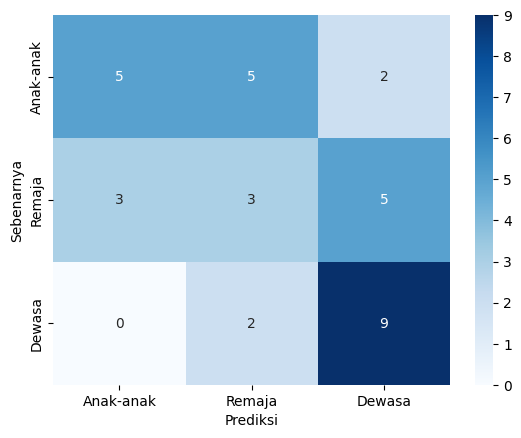

In [10]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Anak-anak', 'Remaja', 'Dewasa'], yticklabels=['Anak-anak', 'Remaja', 'Dewasa'])
plt.xlabel('Prediksi')
plt.ylabel('Sebenarnya')
plt.show() 

In [11]:
# Menyimpan model
joblib.dump(model, "famscreen_model.pkl") 


['famscreen_model.pkl']

In [12]:
# Memuat model Random Forest yang telah disimpan
model = joblib.load('famscreen_model.pkl')

In [13]:
# Prediksi menggunakan model yang dimuat
age_category_pred = model.predict(X_test)
print(age_category_pred)

[1 2 1 2 0 2 2 1 1 1 1 2 2 1 1 0 0 0 0 2 2 1 2 0 0 2 2 2 2 1 0 2 2 2]


In [ ]:
import cv2
import dlib
import numpy as np
import joblib
from skimage.feature import local_binary_pattern

# Fungsi untuk ekstraksi fitur LBP (seperti yang sudah dijelaskan sebelumnya)
def extract_lbp_features(image, radius=2, n_points=16):
    lbp = local_binary_pattern(image, n_points, radius, method="uniform")
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)  # Normalisasi
    return lbp_hist

# Fungsi untuk mendeteksi wajah dan cropping menggunakan dlib
def detect_face_dlib(img):
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
    
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    
    faces = detector(gray)
    if len(faces) == 0:
        return None  # Tidak ada wajah terdeteksi
    
    face = faces[0]
    landmarks = predictor(gray, face)
    landmarks_points = np.array([[p.x, p.y] for p in landmarks.parts()])
    
    convex_hull = ConvexHull(landmarks_points)
    vertices = convex_hull.vertices
    
    mask = np.zeros(gray.shape, dtype=np.uint8)
    cv2.fillPoly(mask, [landmarks_points[vertices]], 255)
    
    x, y, w, h = cv2.boundingRect(mask)
    cropped_face = img[y:y+h, x:x+w]
    
    return cropped_face

# Fungsi untuk memproses gambar dan memprediksi
def predict_age_category(image_path, model):
    # Baca gambar
    image = cv2.imread(image_path)
    
    # Deteksi wajah dan crop gambar wajah
    cropped_face = detect_face_dlib(image)
    
    if cropped_face is not None:
        # Ekstraksi fitur LBP dari gambar wajah yang terdeteksi
        enhanced_img = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2GRAY)  # Pastikan gambar grayscale
        lbp_features = extract_lbp_features(enhanced_img)
        
        # Prediksi kategori umur menggunakan model
        lbp_features = np.array(lbp_features).reshape(1, -1)  # Ubah menjadi format 2D untuk prediksi
        age_category_pred = model.predict(lbp_features)
        
        return age_category_pred[0]
    else:
        return None  # Tidak ada wajah terdeteksi

# Memuat model yang sudah disimpan
model = joblib.load('famscreen_model.pkl')

# Contoh menggunakan gambar baru untuk prediksi
image_path = "Images/ImageFile.jpg"  # Ganti dengan path gambar yang ingin diuji
predicted_age_category = predict_age_category(image_path, model)

if predicted_age_category is not None:
    print(f"Kategori usia yang diprediksi: {predicted_age_category}")
else:
    print("Tidak ada wajah terdeteksi dalam gambar.")


Kategori usia yang diprediksi: 2


/Volumes/Lexar E6/Projek/FamScreen_ML/penv/lib/python3.13/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
